# Improve the ancestral probability layer

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
import numpy as np
import tensorflow as tf
from learnMSA import msa_hmm
from matplotlib import pyplot as plt

In [2]:
def run_tests(runner_func, name, datasets=["homfam", "balifam10000"]):
    stdout = sys.stdout
    for dataset in datasets:
        result_file = "test_results/"+name+"_results."+dataset+".txt"
        if os.path.exists(result_file):
            continue 
        sys.stdout = open("test_results/"+name+"."+dataset+".log", "a")
        with open(result_file, "a") as results_file:
            for file in os.listdir("../MSA-HMM-Analysis/data/"+dataset+"/train"):
                if file.endswith(".fasta"):
                    family = ".".join(file.split(".")[:-1])
                    train_filename = "../MSA-HMM-Analysis/data/"+dataset+"/train/" + file
                    ref_filename = "../MSA-HMM-Analysis/data/"+dataset+"/refs/" + family + ".ref"
                    best_alignment, sp = runner_func(train_filename, ref_filename)
                    results_file.write(family + " " + str(sp) + "\n")
                    results_file.flush()
        sys.stdout.close()
    sys.stdout = stdout

def check_results(filepath, scale=1.):
    with open(filepath, "r") as file:
        scores = {line.strip().split(" ")[0] : float(line.strip().split(" ")[1])*scale for line in file if len(line.strip()) > 0}
        return scores
    
def compare_results(scores, ref_scores):
    mean_score =  np.mean(list(scores.values()))
    mean_ref_score = np.mean(list(ref_scores.values()))
    print("scores mean:", mean_score, "ref_scores mean:", mean_ref_score)
    diffs = [(s-ref_scores[f], f, s) for f,s in scores.items()]
    diffs.sort()
    diffs = [(f,np.round(d, 3),np.round(s, 3)) for d,f,s in diffs]
    print(diffs[:5], "...", diffs[-5:])

def compare_to_ref(name, 
                   datasets=["homfam", "balifam10000"],
                   scale=100):
    for dataset in datasets:
        print(dataset)
        compare_results(check_results("test_results/"+name+"_results."+dataset+".txt", scale=scale), 
                        check_results(r"../MSA-HMM-Analysis/results/msa_hmm2/msa_hmm2."+dataset+".out"))

def compare_to_baseline(name, 
                   datasets=["homfam", "balifam10000"],
                   scale=100):
    for dataset in datasets:
        print(dataset)
        compare_results(check_results("test_results/"+name+"_results."+dataset+".txt", scale=scale), 
                        check_results("test_results/baseline_results."+dataset+".txt", scale=scale))
        
def print_and_plot(alignment, 
                   max_seq = 20, 
                   seqs_to_plot = [0,1,2], 
                   seq_ids = False, 
                   plot_model=True, 
                   plot_anc_probs=True,
                   plot_rate_matrices=True):
    # print the alignment
    msa = alignment.to_string()
    i = [l.name for l in alignment.encoder_model.layers].index("AncProbsLayer")
    anc_probs_layer = alignment.encoder_model.layers[i]
    ds = msa_hmm.train.make_dataset(alignment.indices, 
                            alignment.batch_generator,
                            alignment.batch_size, 
                            shuffle=False)
    ll = alignment.model.predict(ds) + alignment.prior
    for i,s in enumerate(msa[:max_seq]):
        tau = anc_probs_layer.make_tau(alignment.indices[i])
        param_string = "l=%.2f" % (ll[i]) + "_t=%.2f" % tau
        if seq_ids:
            print(f">{alignment.fasta_file.seq_ids[i]} "+param_string)
        else:
            print(">"+param_string)
        print(s)
    if len(msa) > max_seq:
        print(len(msa) - max_seq, "sequences omitted.")
    if plot_model:
        #plot the model
        fig = plt.figure(frameon=False)
        ax = fig.add_axes([0, 0, 1, 1])
        msa_hmm.vis.plot_hmm(alignment, ax, 
                 seq_indices=alignment.indices[seqs_to_plot],
                 path_colors=["#CC6600", "#0000cc", "#00cccc"])   
    if plot_anc_probs:
        msa_hmm.vis.plot_anc_probs(best_alignment, seqs=seqs_to_plot)
    if plot_rate_matrices:
        msa_hmm.vis.plot_rate_matrices(best_alignment)

In [3]:
def reduce_multinomial_emissions(B, inputs):
    """ Emission function that models a random experiment where one of 
        m rate matrices is selected under a learned multinomial distribution per match state. 
        Args:
            B: List of 2 emission matricies with shapes [(q, s+1), (q, m+1)]
            inputs: Stacked ancestral probabilities. Shape: (b, m*(s+1))
    """
    s = tf.shape(B[0])[-1]
    m = tf.shape(B[1])[-1]-1
    inputs = tf.reshape(inputs, (tf.shape(inputs)[0], m, s))
    # reduce the alphabet dimension first for memory efficiency
    emission_prob = tf.einsum("qs,bms->bqm", B[0], inputs)
    multinomial = B[1][:,:-1]
    multinomial_emission_prob = tf.einsum("bqm,qm->bq", emission_prob, multinomial)
    terminal_emissions = tf.expand_dims(B[1][:,-1], 0) 
    terminal_inputs = inputs[:,:1,-1] 
    terminal_posterior = terminal_inputs * terminal_emissions
    multinomial_emission_prob += terminal_posterior
    return multinomial_emission_prob

#currently unused, memory intensive for long models
def match_rate_emissions(B, inputs):
    """ Emission function for the case that each match state receives as different input.
        Args:
            B: List of 2 emission matricies with shapes [(q, s+1), (q, k+1)]
            inputs: Stacked ancestral probabilities. Shape: (b, k*s)
    """
    B = B[0]
    model_length = tf.cast((tf.shape(B)[0]-3)/2, tf.int32)
    s = tf.shape(B)[1]
    inputs = tf.reshape(inputs, (-1,model_length+1,s))
    B_part = tf.expand_dims(B[:model_length+1], 0)
    first_insert_and_matches = tf.reduce_sum(B_part * inputs, -1)
    other_inserts = tf.linalg.matvec(B[model_length+1:], inputs[:,0,:])
    return tf.concat([first_insert_and_matches, other_inserts], axis=1)


class SimpleDirichletPrior():
    def __init__(self, alpha, insertions=False):
        self.alpha = alpha
        self.insertions = insertions
        
    def __call__(self, B):
        model_length = int((tf.shape(B)[0]-2)/2)
        if self.insertions:
            B = B[:-1,:-1]
        else:
            B = B[1:model_length+1,:-1]
        prior = tf.math.log(B)
        prior = tf.reduce_sum(self.alpha * prior, -1)
        return prior
    
def get_encoder_weights(keep_tau, tau_init):
    def _extract_encoder_weights_callback(encoder_model, pos_expand, expansion_lens, pos_discard):
        i = [l.name for l in encoder_model.layers].index("AncProbsLayer")
        anc_probs_layer = encoder_model.layers[i]
        for w in anc_probs_layer.weights:
            if "tau_kernel" in w.name:
                tau_kernel = w
            elif "exchangeability_kernel" in w.name:
                exchangeability_kernel = w
            elif "per_matrix_rates_kernel" in w.name:
                matrix_rates_kernel = w
            elif "equilibrium_kernel" in w.name:
                equilibrium_kernel = w
        if not keep_tau:
            tau_kernel = tf.constant(tau_init)
        if anc_probs_layer.per_matrix_rate:
            return [tf.constant_initializer(tau_kernel.numpy()), 
                    tf.constant_initializer(exchangeability_kernel.numpy()), 
                    tf.constant_initializer(equilibrium_kernel.numpy()),
                    tf.constant_initializer(matrix_rates_kernel.numpy())]
        else:
            return [tf.constant_initializer(tau_kernel.numpy()),
                    tf.constant_initializer(exchangeability_kernel.numpy()),
                    tf.constant_initializer(equilibrium_kernel.numpy())]
    return _extract_encoder_weights_callback
    
    
def get_encoder_weights_positional(encoder_model, pos_expand, expansion_lens, pos_discard):
    i = [l.name for l in encoder_model.layers].index("AncProbsLayer")
    anc_probs_layer = encoder_model.layers[i]
    for w in anc_probs_layer.weights:
        if "tau_kernel" in w.name:
            tau_kernel = w
        elif "exchangeability_kernel" in w.name:
            exchangeability_kernel = w
        elif "matrix_rates_kernel" in w.name:
            matrix_rates_kernel = w
    matrix_rates = msa_hmm.align.apply_mods(matrix_rates_kernel[1:],
                                             pos_expand, 
                                             expansion_lens, 
                                             pos_discard,
                                             inverse_softplus(1.))
    matrix_rates = np.concatenate([matrix_rates_kernel[:1].numpy(), matrix_rates], axis=0)
    anc_probs_layer = encoder_model.layers[i]
    return [tf.constant_initializer(-3), #reset tau
            tf.constant_initializer(exchangeability_kernel.numpy()), 
            tf.constant_initializer(matrix_rates)]

### Baseline 
Test the new AncProbsLayer with settings resembling learnMSA's default behavior. The only real difference to the original learnMSA is that tau is no longer hard constrained but now passed through a softplus. Usually this should not make a large difference, however, before it was possible for the gradients to vanish if tau_kernel < 0.

In [4]:
def run_learnMSA_baseline(train_filename, ref_filename, num_runs = 5):
    config = dict(msa_hmm.config.default)
    out_filename = "../MSA-HMM-Analysis/results/learnMSA_new/alignments/" + train_filename.split("/")[-1].split(".")[0] + ".projection.fasta"
    config["transposed"] = True
    return msa_hmm.align.run_learnMSA(num_runs, 
                                      train_filename,
                                      out_filename,
                                      config, 
                                      ref_filename=ref_filename, 
                                      verbose=True)

Training of 1 independent models on file egf.fasta
Configuration:
transition_init : {'begin_to_match': <learnMSA.msa_hmm.Configuration.EntryInitializer object at 0x7f38500c2f40>, 'match_to_end': <learnMSA.msa_hmm.Configuration.ExitInitializer object at 0x7f38500c2970>, 'match_to_match': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7f38500c2100>, 'match_to_insert': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7f38500c2fd0>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f38500c2250>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f38500c21c0>, 'match_to_delete': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7f38500c2280>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f38500c2a90>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f38500c2cd0>, 'left_flank_loop': <tensorflow.python.ops.init_ops_v2.

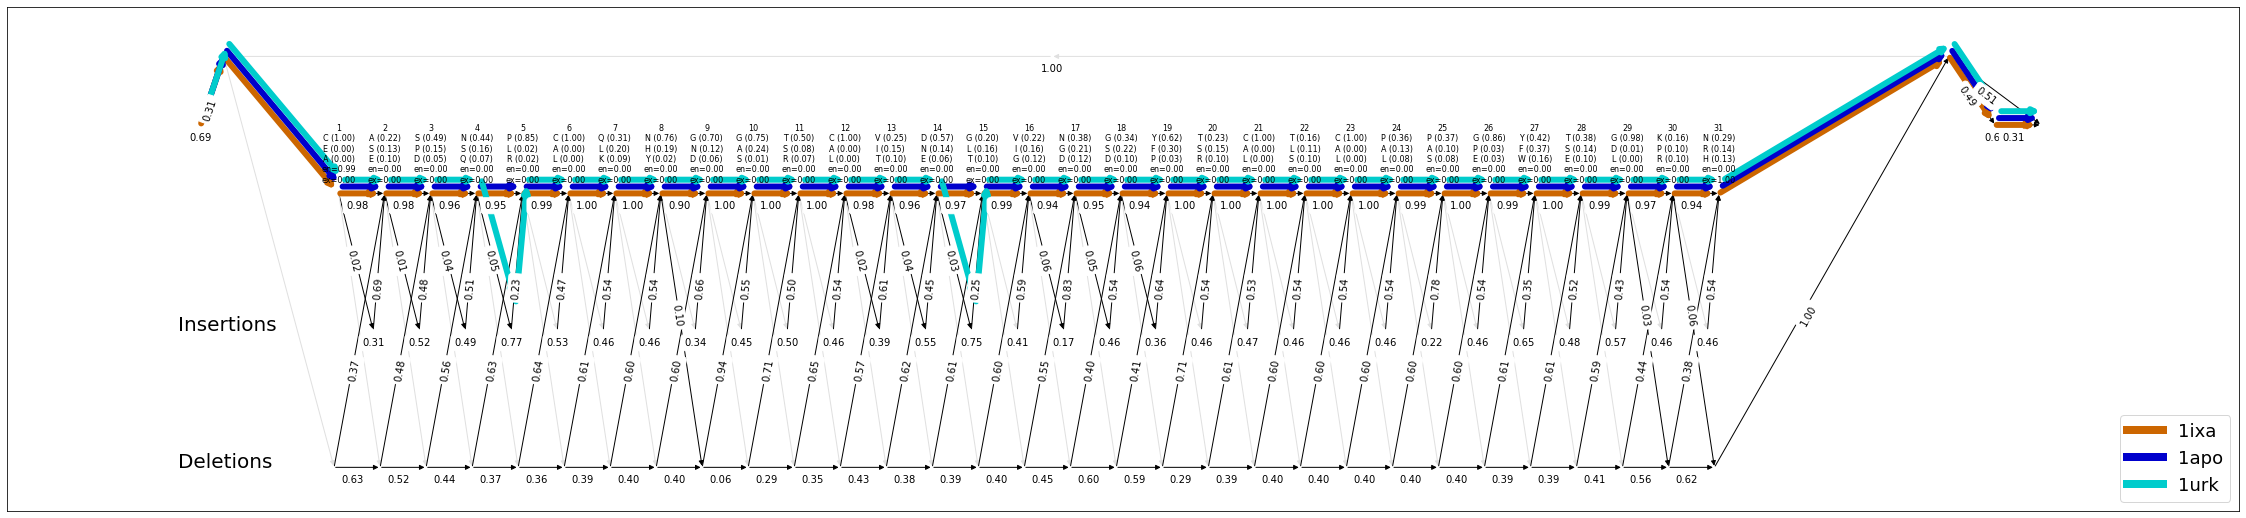

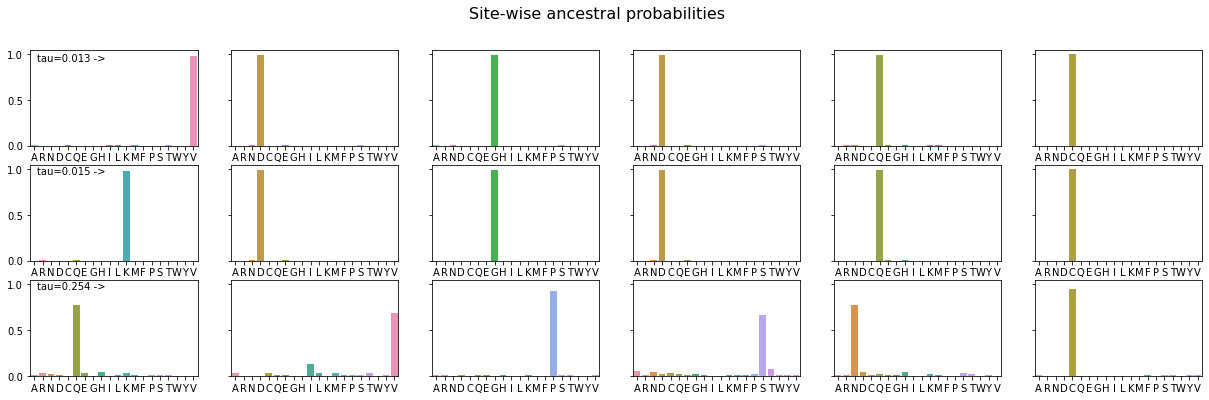

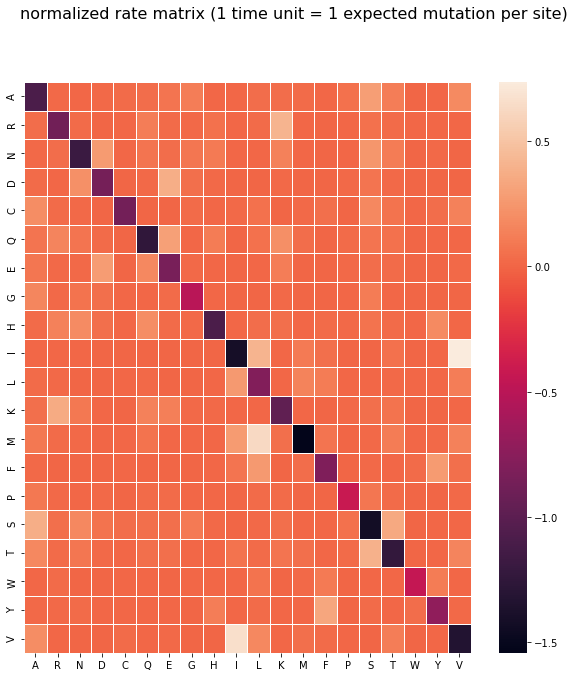

In [5]:
f = "egf"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_baseline(train_filename, ref_filename, num_runs=1)
print_and_plot(best_alignment) 

In [5]:
run_tests(run_learnMSA_baseline, "baseline_untied_segment", datasets=["balifam10000"])

In [6]:
#make sure that baseline reproduces the results of the original learnMSA
compare_to_ref("baseline")

homfam
scores mean: 79.64971567684702 ref_scores mean: 80.26063829787235
[('rvp', -35.55, 32.95), ('phc', -32.303, 37.097), ('gluts', -15.405, 60.695), ('rhv', -9.027, 15.973), ('seatoxin', -8.067, 70.833)] ... [('tgfb', 5.597, 83.797), ('cyt3', 5.665, 76.165), ('DEATH', 6.085, 83.185), ('peroxidase', 10.574, 68.774), ('cryst', 11.229, 92.229)]
balifam10000
scores mean: 75.48473565061919 ref_scores mean: 75.71666666666665
[('PF00625.10000', -11.714, 26.386), ('PF02878.10000', -8.09, 73.51), ('PF04082.10000', -7.233, 53.367), ('PF01814.10000', -2.922, 81.978), ('PF00202.10000', -2.785, 43.415)] ... [('PF07654.10000', 2.629, 81.429), ('PF02836.10000', 3.295, 89.595), ('PF00037.10000', 3.791, 91.091), ('PF13393.10000', 6.403, 44.903), ('PF14604.10000', 6.496, 77.296)]


In [7]:
#make sure that baseline reproduces the results of the original learnMSA
compare_to_ref("baseline_untied_segment")

homfam
scores mean: 79.35105290142454 ref_scores mean: 80.26063829787235
[('phc', -32.388, 37.012), ('tRNA-synt_2b', -18.432, 31.368), ('adh', -18.186, 47.114), ('peroxidase', -12.329, 45.871), ('rvp', -10.922, 57.578)] ... [('cyt3', 4.352, 74.852), ('Ald_Xan_dh_2', 4.52, 21.02), ('ins', 6.778, 95.978), ('sti', 7.669, 82.269), ('cryst', 11.229, 92.229)]
balifam10000
scores mean: 76.1062540265183 ref_scores mean: 75.71666666666665
[('PF13365.10000', -5.803, 22.497), ('PF13393.10000', -3.555, 34.945), ('PF00687.10000', -2.596, 74.904), ('PF13561.10000', -2.248, 67.352), ('PF00155.10000', -1.957, 44.343)] ... [('PF01814.10000', 3.347, 88.247), ('PF00037.10000', 3.791, 91.091), ('PF00625.10000', 5.124, 43.224), ('PF14604.10000', 5.908, 76.708), ('PF04082.10000', 9.142, 69.742)]


### Baseline but keep tau in model surgery

In [8]:
def extract_encoder_weights(encoder_model, pos_expand, expansion_lens, pos_discard):
    """ A simple callback that can be passed to learnMSA via the config to extract the parameters 
        of the AncProbsLayer after each iteration of model surgery and pass them to the next model.
        The default behavior without the extractor is that the weights are re-initialized each time.
    """
    i = [l.name for l in encoder_model.layers].index("AncProbsLayer")
    anc_probs_layer = encoder_model.layers[i]
    return [tf.constant_initializer(w.numpy()) for w in anc_probs_layer.weights]

def run_learnMSA_baseline_keep_tau(train_filename, ref_filename, num_runs = 3):  
    config = dict(msa_hmm.config.default)
    config["encoder_weight_extractor"] = extract_encoder_weights
    out_filename = "../MSA-HMM-Analysis/results/learnMSA_new/alignments/" + train_filename.split("/")[-1].split(".")[0] + ".projection.fasta"
    return msa_hmm.align.run_learnMSA(num_runs, 
                                      train_filename,
                                      out_filename,
                                      config, 
                                      ref_filename=ref_filename, 
                                      verbose=True)

In [9]:
run_tests(run_learnMSA_baseline_keep_tau, "baseline_keep_tau", datasets=["homfam"])

In [10]:
compare_to_baseline("baseline_keep_tau")

homfam
scores mean: 79.70448354759833 ref_scores mean: 79.64971567684702
[('gluts', -24.484, 36.211), ('peroxidase', -17.161, 51.613), ('cryst', -12.292, 79.938), ('Rhodanese', -6.67, 70.174), ('TNF', -5.827, 74.892)] ... [('blmb', 5.932, 70.404), ('HMG_box', 9.065, 97.309), ('oxidored_q6', 15.853, 70.775), ('rvp', 32.882, 65.832), ('phc', 38.228, 75.325)]
balifam10000
scores mean: 74.89694429133138 ref_scores mean: 75.48473565061919
[('PF13393.10000', -14.226, 30.677), ('PF07679.10000', -8.942, 74.889), ('PF13561.10000', -7.539, 64.638), ('PF13365.10000', -6.671, 20.04), ('PF00037.10000', -6.34, 84.751)] ... [('PF00018.10000', 2.465, 86.818), ('PF00625.10000', 3.149, 29.535), ('PF00078.10000', 3.348, 90.953), ('PF04082.10000', 9.732, 63.1), ('PF02878.10000', 10.861, 84.371)]


### Baseline with equilibrium sampling

In [11]:
def run_learnMSA_equilibrium_sample(train_filename, ref_filename, num_runs = 5):  
    config = dict(msa_hmm.config.default)
    config["equilibrium_sample"] = True
    out_filename = "../MSA-HMM-Analysis/results/learnMSA_new/alignments/" + train_filename.split("/")[-1].split(".")[0] + ".projection.fasta"
    return msa_hmm.align.run_learnMSA(num_runs, 
                                      train_filename,
                                      out_filename,
                                      config, 
                                      ref_filename=ref_filename, 
                                      verbose=True)

In [12]:
run_tests(run_learnMSA_equilibrium_sample, "baseline_equilibrium_sample", datasets=["balifam10000"])

In [13]:
compare_to_baseline("baseline_equilibrium_sample")

homfam
scores mean: 79.59364181843694 ref_scores mean: 79.64971567684702
[('tRNA-synt_2b', -22.113, 29.361), ('Acetyltransf', -19.328, 42.313), ('DEATH', -8.355, 74.83), ('gluts', -8.126, 52.568), ('tgfb', -6.582, 77.215)] ... [('sti', 3.472, 81.401), ('rhv', 6.944, 22.916), ('oxidored_q6', 8.876, 63.798), ('rvp', 25.913, 58.863), ('phc', 29.896, 66.993)]
balifam10000
scores mean: 76.23384301896236 ref_scores mean: 75.48473565061919
[('PF13365.10000', -10.266, 16.445), ('PF13561.10000', -4.94, 67.237), ('PF13393.10000', -3.975, 40.928), ('PF00037.10000', -2.488, 88.604), ('PF00150.10000', -2.13, 58.093)] ... [('PF00078.10000', 4.583, 92.188), ('PF01814.10000', 7.346, 89.324), ('PF02878.10000', 8.742, 82.252), ('PF04082.10000', 12.731, 66.098), ('PF00625.10000', 14.73, 41.116)]


### Experiment 1: Constant sites

As shown with learnMSA 1.0, alignment accuracy can be increased, if the fixed one-hot encoding of sites is replaced by the expected amino acid distribution after a short evolutionary time under a substitution model. The evolutionary time is learned jointly with the HMM.

However, the substitution rate varies among sites. Some sites (~18% in the alignments used to train the LG rate matrix) are even constant. Those may be in conflict with highly diverse sites when using a single fixed rate matrix and a global evolutionary time for the whole sequence. 

As a solution, we train an extended pHMM that learns an additional Bernoulli distribution per match state that is used to choose between the regular rate matrix used by learnMSA and a matrix of zeros for constant sites. 

$P(S \mid M) = \sum_{k=1}^M p_k Anc(S, Q_k) \cdot P_M$

with

$Anc(S, Q_k) = S \cdot expm(\tau_S Q_k)$

($S$ is a sequence position and $M$ an match state. Left away indices for simplicity.)

In [7]:
def run_learnMSA_constant_sites(train_filename, ref_filename, num_runs = 5):
    
    epsilon=1e-32
    R, p = msa_hmm.anc_probs.parse_paml(msa_hmm.anc_probs.LG_paml, msa_hmm.fasta.alphabet[:-1])
    exchangeability_init = np.stack([R,np.zeros_like(R)], axis=0)
    exchangeability_init = msa_hmm.anc_probs.inverse_softplus(exchangeability_init + epsilon)
    equilibrium_init = np.log(p)
    equilibrium_init = np.stack([equilibrium_init]*2, axis=0)
    
    config = dict(msa_hmm.config.default)
    c = 0. #increase c to shift to increase p_0
    config["emission_init"] = [msa_hmm.config.make_default_emission_init(), 
                               msa_hmm.config.EmissionInitializer(np.array([c, -c]))]
    config["insertion_init"] = [msa_hmm.config.make_default_insertion_init(), 
                                                tf.constant_initializer([c, -c])]
    config["encoder_initializer"] = [tf.constant_initializer(-3), 
                                     tf.constant_initializer(exchangeability_init), 
                                     tf.constant_initializer(equilibrium_init)]
    config["kernel_dim"] = [25, 2]
    config["num_rate_matrices"] = 2
    config["emission_func"] = reduce_multinomial_emissions
    config["emission_matrix_generator"] = [msa_hmm.cell.make_default_emission_matrix]*2
    config["emission_prior"] = [msa_hmm.cell.AminoAcidPrior(), 
                                # use a prior that strongly favors p_LG = 1 and p_constant = 0
                                SimpleDirichletPrior(alpha = np.array([[180.0, 0.]]))]
    config["equilibrium_sample"] = True
    config["frozen_insertions"] = [True, True]
    out_filename = "../MSA-HMM-Analysis/results/learnMSA_new/alignments/" + train_filename.split("/")[-1].split(".")[0] + ".projection.fasta"
    return msa_hmm.align.run_learnMSA(num_runs, 
                                      train_filename,
                                      out_filename,
                                      config, 
                                      model_generator=msa_hmm.train.default_model_generator,
                                      ref_filename=ref_filename, 
                                      verbose=True)

Training of 1 independent models on file egf.fasta
Configuration:
transition_init : {'begin_to_match': <learnMSA.msa_hmm.Configuration.EntryInitializer object at 0x7fd2d80c9d90>, 'match_to_end': <learnMSA.msa_hmm.Configuration.ExitInitializer object at 0x7fd2d80c9700>, 'match_to_match': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fd2d80c9490>, 'match_to_insert': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fd2d80c9b20>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fd2d80c9370>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fd2d80c96d0>, 'match_to_delete': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fd2d80c90a0>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fd2d80c9a00>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fd2d80c92b0>, 'left_flank_loop': <tensorflow.python.ops.init_ops_v2.

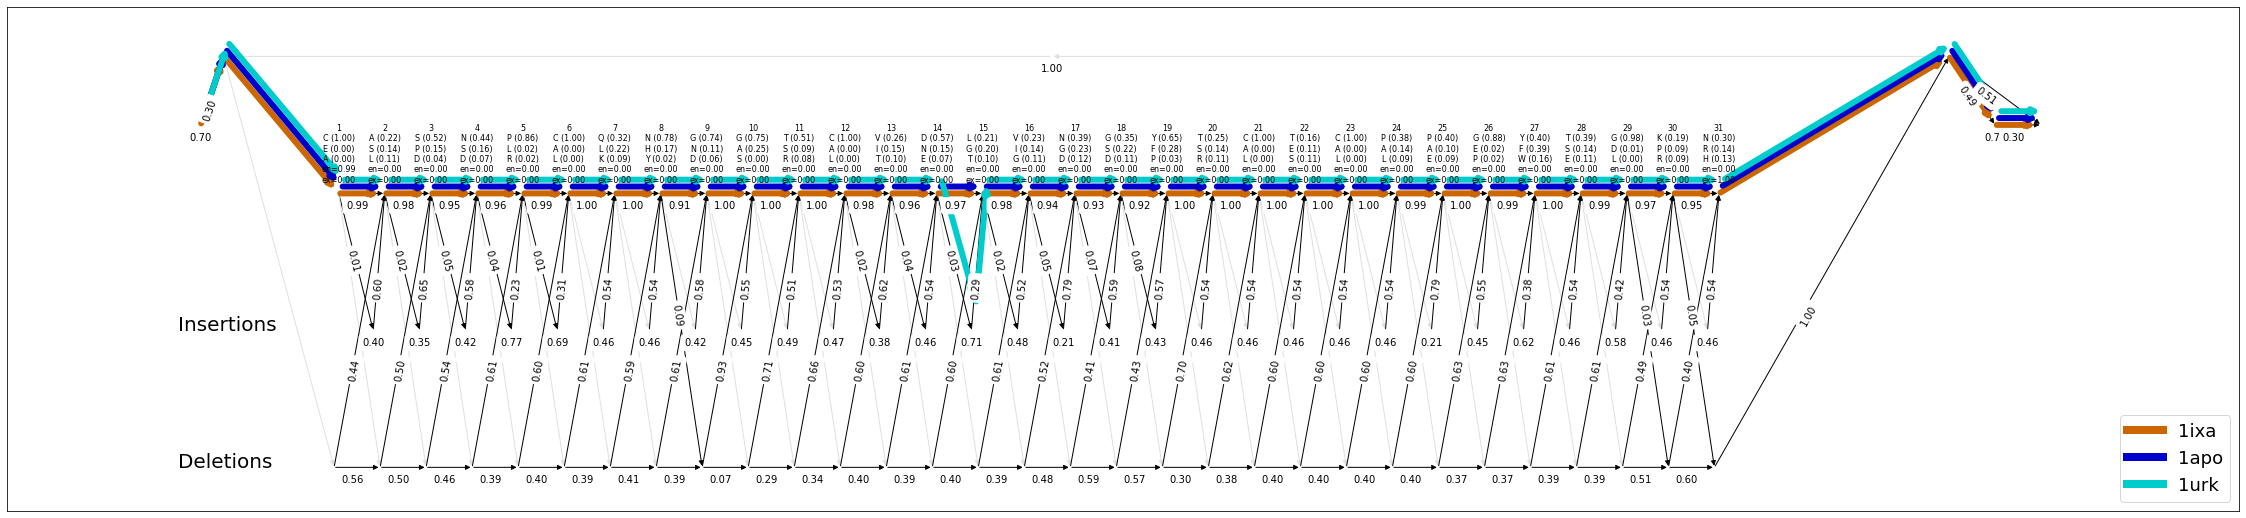

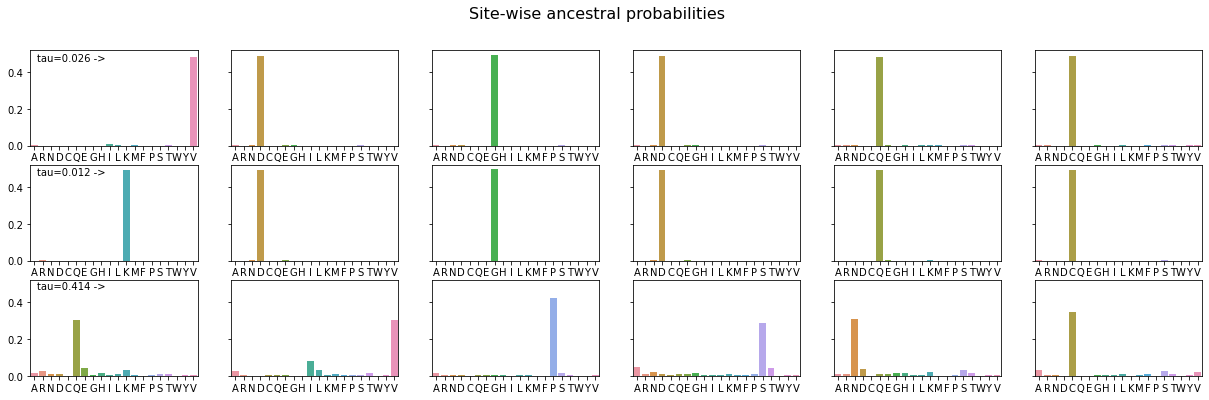

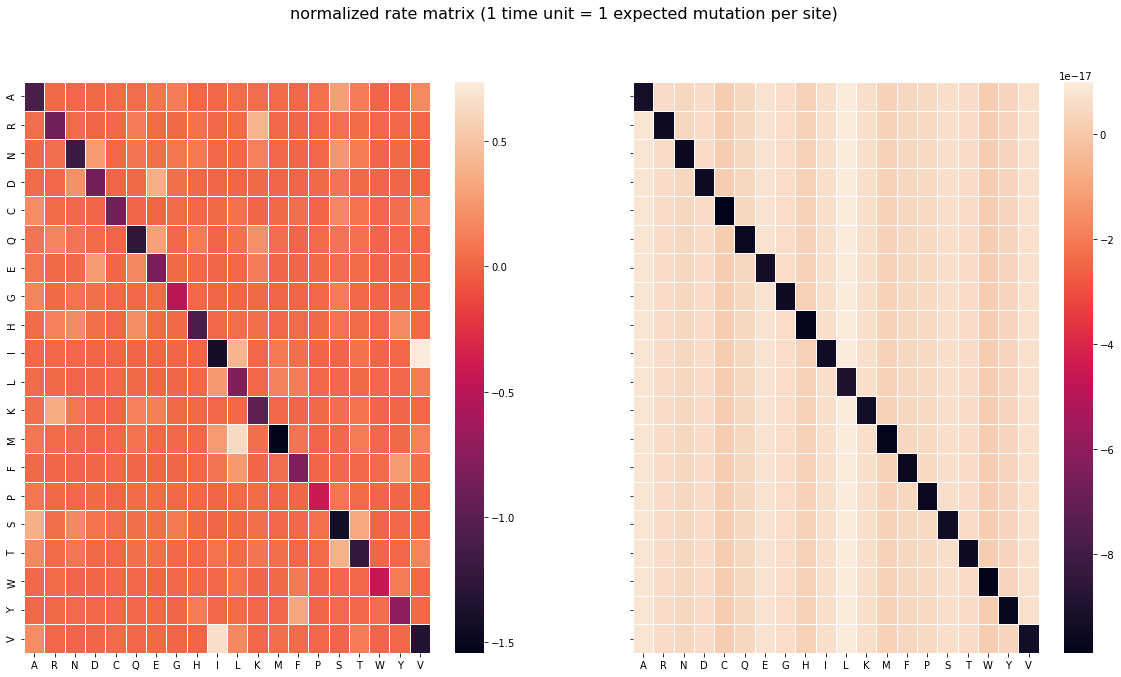

In [8]:
f = "egf"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_constant_sites(train_filename, ref_filename, num_runs=1)
print_and_plot(best_alignment) 

As seen in the cell below, when using a strict prior for the multinomials, learnMSA correctly finds the conserved cysteines in the EGF family and applies the constant rate matrix, while it relies on LG for the rest of the sequence.

*The same effect could be modeled with a single rate matrix and a learnable evolutionary time per match state.*

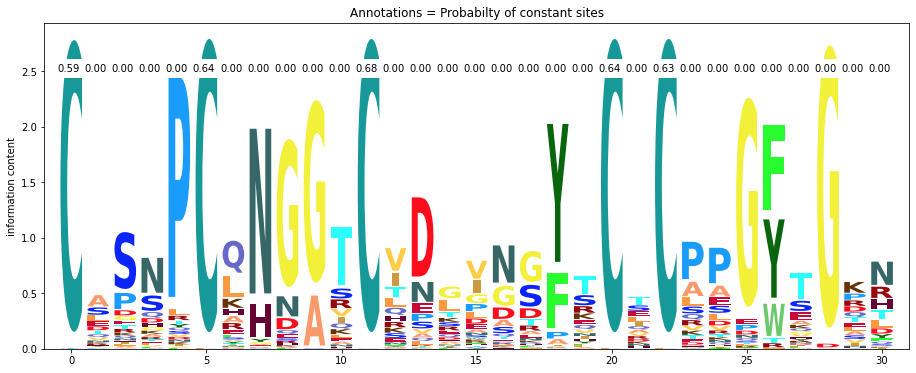

In [20]:
fig, ax = plt.subplots()
msa_hmm.vis.make_logo(best_alignment, ax)
B = best_alignment.msa_hmm_layer.cell.make_B()
model_len = best_alignment.msa_hmm_layer.cell.length
for i,p in enumerate(B[1][1:1+model_len,1]):
    plt.annotate("%.2f" % p, (i-0.5, 2.5), backgroundcolor="w")
plt.title("Annotations = Probabilty of constant sites");

In [17]:
run_tests(run_learnMSA_constant_sites, "constant_sites_equilibrium_sample", datasets = ["balifam10000"])

In [18]:
compare_to_baseline("constant_sites")

homfam
scores mean: 79.48140069873058 ref_scores mean: 79.64971567684702
[('tRNA-synt_2b', -21.785, 29.689), ('adh', -14.121, 53.369), ('peroxidase', -9.032, 59.742), ('Ald_Xan_dh_2', -5.886, 15.424), ('lyase_1', -5.728, 66.543)] ... [('rhv', 4.896, 20.869), ('oxidored_q6', 5.969, 60.891), ('HMG_box', 9.065, 97.309), ('gluts', 18.347, 79.042), ('phc', 25.598, 62.696)]
balifam10000
scores mean: 76.69680077147422 ref_scores mean: 75.48473565061919
[('PF00078.10000', -5.58, 82.025), ('PF00505.10000', -4.469, 92.486), ('PF02836.10000', -4.175, 85.421), ('PF07654.10000', -2.449, 78.98), ('PF01814.10000', -1.567, 80.411)] ... [('PF00625.10000', 5.41, 31.796), ('PF13378.10000', 5.7, 78.831), ('PF02878.10000', 7.285, 80.795), ('PF13365.10000', 9.843, 36.554), ('PF04082.10000', 10.563, 63.93)]


In [19]:
compare_to_baseline("constant_sites_equilibrium_sample")

homfam
scores mean: 78.8711598669827 ref_scores mean: 79.64971567684702
[('tRNA-synt_2b', -26.249, 25.225), ('adh', -20.671, 46.819), ('peroxidase', -16.871, 51.903), ('cryst', -10.653, 81.577), ('DEATH', -8.93, 74.256)] ... [('icd', 3.647, 89.233), ('sti', 3.906, 81.835), ('rhv', 4.077, 20.05), ('blmb', 4.954, 69.426), ('gluts', 19.053, 79.747)]
balifam10000
scores mean: 76.2352002592717 ref_scores mean: 75.48473565061919
[('PF13393.10000', -3.419, 41.484), ('PF13561.10000', -1.891, 70.286), ('PF00625.10000', -1.767, 24.618), ('PF00202.10000', -1.455, 41.96), ('PF00037.10000', -1.284, 89.807)] ... [('PF01814.10000', 3.918, 85.896), ('PF13378.10000', 3.949, 77.08), ('PF01381.10000', 4.453, 68.259), ('PF04082.10000', 5.627, 58.994), ('PF13365.10000', 15.427, 42.138)]


### Experiment 2: Learn a family specific rate matrix.

Like the baseline but with a trainable rate matrix $Q$. Both the symmetric exchangeabilty matrix and the stationary distribution $\pi$ are trainable. We want to prevent a cheating model that maximizes likelihood by mutating all amino acids to a single one.

<img src="doc/anc_probs.svg" width="800">

Reverse time sequence to consensus does not work in this case. $\mathcal{P}$ has only a horizontal constraint (sum to one) but not vertically. Because of this constraint, if $\mathcal{P}$ and $P(*\mid M)$ are freely trainable, both can converge to a solution with high "fake" likelihood that favours a single amino acid. In this case each row of $\mathcal{P}$ has a probability of almost 1 at one position and this position is the same for all rows. Consensus to sequence (which is essentially transposing $\mathcal{P}$) prevents this. Now $\mathcal{P}$ sums to one vertically instead of horizontally. This prevents the mapping of all amino acids to a single one, as columns consisting of large probabilities only can not exist anymore. 

In [21]:
def run_learnMSA_family_rate(train_filename, ref_filename, num_runs = 5):
    out_filename = "../MSA-HMM-Analysis/results/learnMSA_new/alignments/" + train_filename.split("/")[-1].split(".")[0] + ".projection.fasta"
    config = dict(msa_hmm.config.default)
    config["trainable_rate_matrices"] = True 
    config["transposed"] = True 
    config["equilibrium_sample"] = False 
    config["matrix_rate_l2"] = 0.
    config["encoder_initializer"] = [tf.constant_initializer(0.), 
                                     tf.constant_initializer(msa_hmm.config.exchangeability_init),
                                     tf.constant_initializer(np.log(msa_hmm.config.p))]
    config["encoder_weight_extractor"] = get_encoder_weights(keep_tau=False, tau_init=0.)
    return msa_hmm.align.run_learnMSA(num_runs, 
                                      train_filename,
                                      out_filename,
                                      config, 
                                      model_generator=msa_hmm.train.default_model_generator,
                                      ref_filename=ref_filename, 
                                      verbose=True)

Training of 1 independent models on file KAS.fasta
Configuration:
transition_init : {'begin_to_match': <learnMSA.msa_hmm.Configuration.EntryInitializer object at 0x7f4b783f2c10>, 'match_to_end': <learnMSA.msa_hmm.Configuration.ExitInitializer object at 0x7f4b783f2880>, 'match_to_match': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7f4b783f2e20>, 'match_to_insert': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7f4b783f2b50>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f4b783f2d00>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f4b783f21c0>, 'match_to_delete': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7f4b783f2310>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f4b783f25e0>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f4b783f2640>, 'left_flank_loop': <tensorflow.python.ops.init_ops_v2.

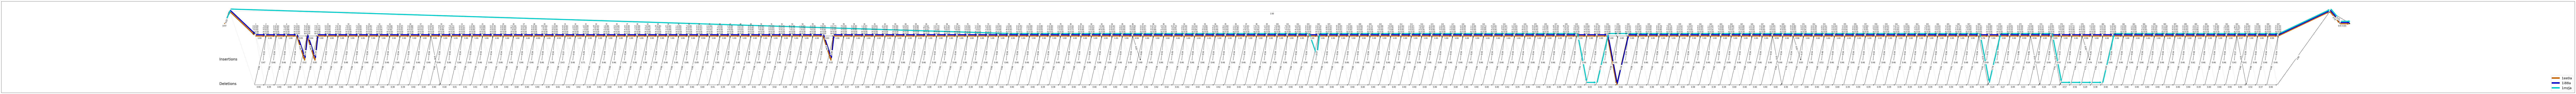

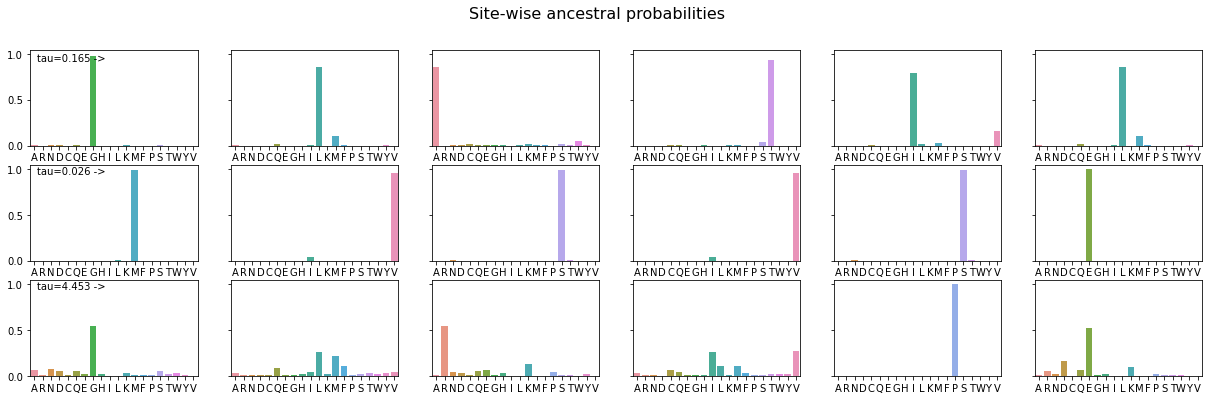

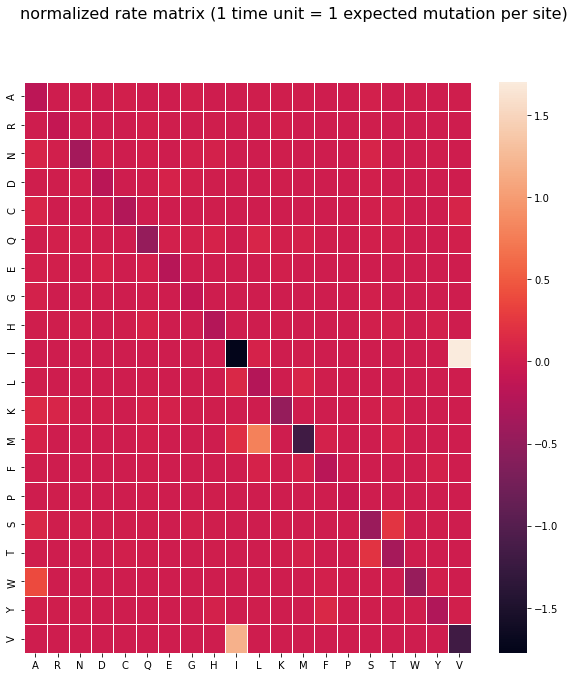

In [27]:
f = "KAS"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_family_rate(train_filename, ref_filename, num_runs=1)
print_and_plot(best_alignment) 

Training of 1 independent models on file int.fasta
Configuration:
transition_init : {'begin_to_match': <learnMSA.msa_hmm.Configuration.EntryInitializer object at 0x7f4b783f2c10>, 'match_to_end': <learnMSA.msa_hmm.Configuration.ExitInitializer object at 0x7f4b783f2880>, 'match_to_match': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7f4b783f2e20>, 'match_to_insert': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7f4b783f2b50>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f4b783f2d00>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f4b783f21c0>, 'match_to_delete': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7f4b783f2310>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f4b783f25e0>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f4b783f2640>, 'left_flank_loop': <tensorflow.python.ops.init_ops_v2.

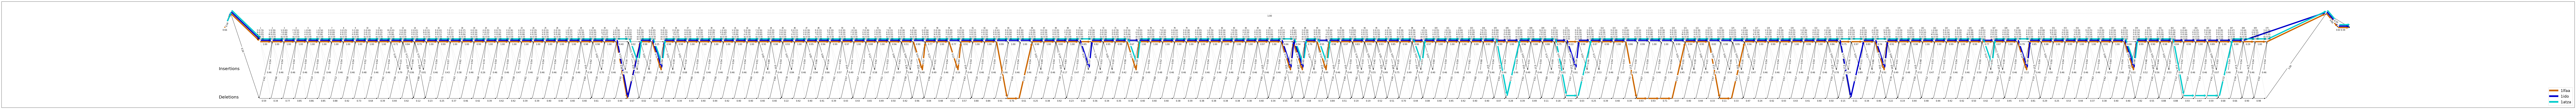

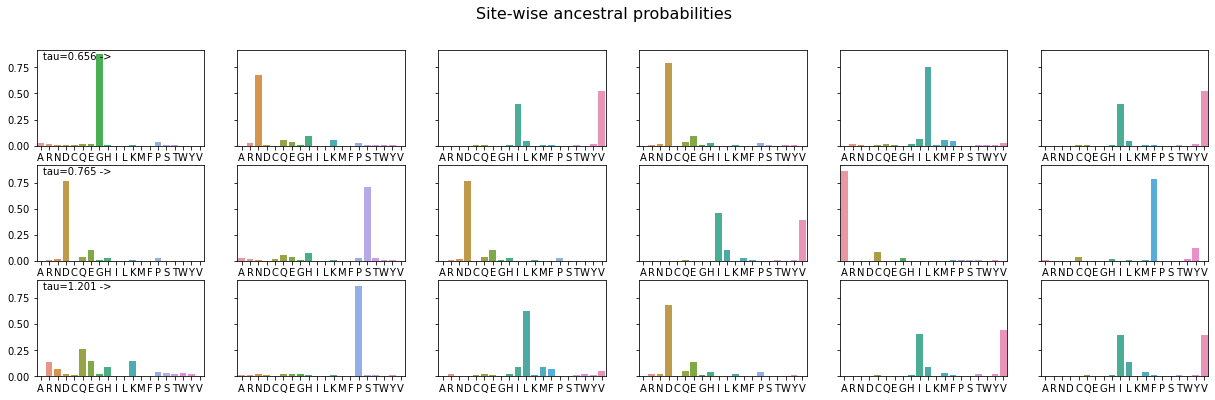

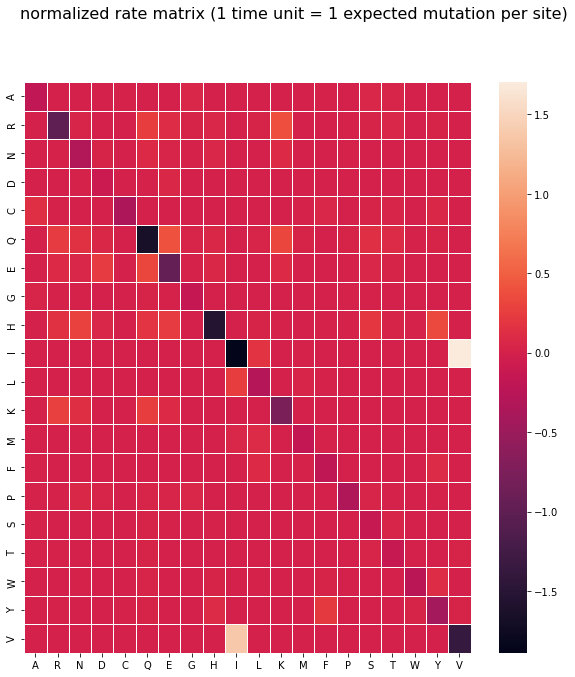

In [23]:
f = "int"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_family_rate(train_filename, ref_filename, num_runs=1)
print_and_plot(best_alignment) 

In [ ]:
run_tests(run_learnMSA_family_rate, "family_rate_new3", datasets=["balifam10000"])

In [6]:
compare_to_baseline("family_rate")

homfam
scores mean: 79.65043422345252 ref_scores mean: 79.64971567684702
[('gluts', -28.363, 32.332), ('Acetyltransf', -12.951, 48.69), ('tgfb', -10.127, 73.671), ('peroxidase', -6.645, 62.129), ('TNF', -6.619, 74.101)] ... [('toxin', 6.767, 91.95), ('HMG_box', 9.065, 97.309), ('seatoxin', 10.88, 81.713), ('adh', 13.128, 80.617), ('phc', 30.811, 67.908)]
balifam10000
scores mean: 75.17328779311786 ref_scores mean: 75.48473565061919
[('PF00150.10000', -25.654, 34.57), ('PF04082.10000', -9.363, 44.004), ('PF00037.10000', -5.859, 85.233), ('PF13393.10000', -4.584, 40.318), ('PF00505.10000', -2.711, 94.244)] ... [('PF00202.10000', 3.718, 47.133), ('PF13365.10000', 4.314, 31.024), ('PF00078.10000', 5.62, 93.224), ('PF00625.10000', 10.258, 36.644), ('PF02878.10000', 11.126, 84.636)]


In [25]:
compare_to_baseline("family_rate_new2")

homfam
scores mean: 79.15507042924425 ref_scores mean: 79.64971567684702
[('tRNA-synt_2b', -20.68, 30.794), ('int', -11.915, 70.1), ('gluts', -10.632, 50.063), ('rvp', -9.54, 23.41), ('blm', -8.796, 84.885)] ... [('kringle', 5.435, 91.083), ('Rhodanese', 6.67, 83.514), ('HMG_box', 8.074, 96.317), ('seatoxin', 12.731, 83.565), ('oxidored_q6', 12.984, 67.907)]
balifam10000
scores mean: 73.23840877227687 ref_scores mean: 75.48473565061919
[('PF13393.10000', -38.694, 6.209), ('PF00202.10000', -14.624, 28.791), ('PF13561.10000', -12.316, 59.861), ('PF00078.10000', -6.337, 81.267), ('PF07679.10000', -5.039, 78.793)] ... [('PF02878.10000', 1.854, 75.364), ('PF00046.10000', 1.968, 98.264), ('PF07654.10000', 2.041, 83.469), ('PF01814.10000', 3.428, 85.406), ('PF00625.10000', 8.833, 35.218)]


In [26]:
compare_to_baseline("family_rate_new3")

homfam
scores mean: 78.79450506036369 ref_scores mean: 79.64971567684702
[('KAS', -19.744, 24.586), ('seatoxin', -12.963, 57.87), ('rvp', -12.449, 20.501), ('cryst', -12.15, 80.079), ('tRNA-synt_2b', -8.927, 42.547)] ... [('Rhodanese', 4.935, 81.779), ('rhv', 6.582, 22.555), ('mofe', 6.746, 76.713), ('HMG_box', 9.065, 97.309), ('oxidored_q6', 13.256, 68.178)]
balifam10000
scores mean: 72.03715247283604 ref_scores mean: 75.48473565061919
[('PF13393.10000', -37.219, 7.684), ('PF13522.10000', -15.361, 52.364), ('PF00202.10000', -15.28, 28.135), ('PF13561.10000', -12.091, 60.086), ('PF04082.10000', -7.565, 45.803)] ... [('PF00046.10000', 1.968, 98.264), ('PF07654.10000', 2.041, 83.469), ('PF13365.10000', 3.441, 30.152), ('PF02878.10000', 4.901, 78.411), ('PF00687.10000', 9.017, 83.922)]


### Experiment 3: Like experiment 1 but trainable rate matrices [not working]

In [83]:
def extract_encoder_weights_no_tau(encoder_model, pos_expand, expansion_lens, pos_discard):
    i = [l.name for l in encoder_model.layers].index("AncProbsLayer")
    anc_probs_layer = encoder_model.layers[i]
    return [tf.constant_initializer(-3), 
            tf.constant_initializer(anc_probs_layer.weights[1].numpy())]

def trainable_matrix_pair_model_generator(num_seq,
                            effective_num_seq,
                            model_length, 
                            config,
                            alphabet_size=25):
    anc_probs_layer = AncProbsLayer(num_seq,
                                    2,
                                    frequencies=config["background_distribution"],
                                    rate_init=config["encoder_initializer"][0],
                                    exchangeability_init=config["encoder_initializer"][1],
                                    trainable_exchangeabilities=config["trainable_exchangeabilities"])
    return generic_model_generator(anc_probs_layer, 
                                    num_seq,
                                    effective_num_seq,
                                    model_length, 
                                    config,
                                    alphabet_size)

def run_learnMSA_trainable_matrix_pair(train_filename, ref_filename, num_runs = 3):
    epsilon=1e-32
    R, p = parse_paml(paml_lines, msa_hmm.fasta.alphabet[:-1])
    exchangeability_init = np.concatenate([R, 
                                           np.zeros_like(R)], axis=0)
    exchangeability_init = inverse_softplus(exchangeability_init + epsilon)

    config = dict(msa_hmm.config.default)
    c = 0. #increase c to shift to increase p_0
    config["emission_init"] = [msa_hmm.config.make_default_emission_init(), 
                               msa_hmm.config.EmissionInitializer(np.array([c, -c]))]
    config["insertion_init"] = [msa_hmm.config.make_default_insertion_init(), 
                                                tf.constant_initializer([c, -c])]
    config["trainable_exchangeabilities"] = True
    config["encoder_initializer"] = [tf.constant_initializer(-3), 
                                     tf.constant_initializer(exchangeability_init)]
    config["background_distribution"] = p
    config["encoder_weight_extractor"] = extract_encoder_weights_no_tau
    config["kernel_dim"] = [25, 2]
    config["emission_func"] = reduce_multinomial_emissions
    config["emission_matrix_generator"] = [msa_hmm.cell.make_default_emission_matrix]*2
    config["emission_prior"] = [msa_hmm.cell.AminoAcidPrior(), 
                                # use a prior that strongly favors p_LG = 1 and p_constant = 0
                                SimpleDirichletPrior(alpha = np.array([[180.0, 0.]]))]
    return run_learnMSA(train_filename, 
                        ref_filename, 
                        trainable_matrix_pair_model_generator,
                        config, 
                        num_runs)

In [ ]:
f = "egf"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_trainable_matrix_pair(train_filename, ref_filename, num_runs=1)

# print the alignment
max_seq = 20
msa = best_alignment.to_string()
for s in msa[:max_seq]:
    print(s)
if len(msa) > max_seq:
    print(len(msa) - max_seq, "sequences omitted.")
    
#plot the model
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
msa_hmm.vis.plot_hmm(best_alignment, ax, 
         seq_indices=[best_alignment.indices[0], 11, best_alignment.indices[-1]],
         path_colors=["#CC6600", "#0000cc", "#00cccc"])  

In [ ]:
anc_probs_layer = best_alignment.encoder_model.layers[-4] 
with np.printoptions(precision=3, linewidth=100000, suppress=True):
    print("tau:\n", anc_probs_layer.make_tau(best_alignment.indices))
    print("frequencies:\n", anc_probs_layer.frequencies[:-1])
    print("learned R_1:\n", anc_probs_layer.make_R(anc_probs_layer.exchangeability_kernel).numpy()[0,:20, :20])
    print("learned R_2:\n", anc_probs_layer.make_R(anc_probs_layer.exchangeability_kernel).numpy()[1,:20, :20])

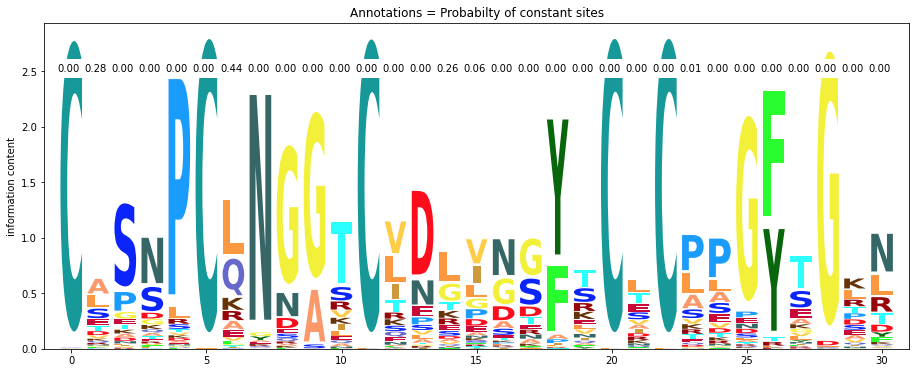

In [52]:
fig, ax = plt.subplots()
msa_hmm.vis.make_logo(best_alignment, ax)
B = best_alignment.msa_hmm_layer.cell.make_B()
model_len = best_alignment.msa_hmm_layer.cell.length
for i,p in enumerate(B[1][1:1+model_len,1]):
    plt.annotate("%.2f" % p, (i-0.5, 2.5), backgroundcolor="w")
plt.title("Annotations = Probabilty of constant sites");

### Experiment 4: Family specific rate matrix and keep it across model surgery iterations

In [84]:
def run_learnMSA_keep_family_rate(train_filename, ref_filename, num_runs = 3):
    epsilon=1e-32
    R, p = parse_paml(paml_lines, msa_hmm.fasta.alphabet[:-1])
    exchangeability_init = inverse_softplus(R + epsilon)

    config = dict(msa_hmm.config.default)
    config["trainable_exchangeabilities"] = True 
    config["encoder_initializer"] = [tf.constant_initializer(-3), 
                                     tf.constant_initializer(exchangeability_init)]
    config["background_distribution"] = p
    #config["encoder_weight_extractor"] = extract_encoder_weights_no_tau
    return run_learnMSA(train_filename, 
                        ref_filename, 
                        config, 
                        baseline_model_generator,
                        num_runs)

Training of 1 independent models on file egf.fasta
Configuration:
transition_init : {'begin_to_match': <learnMSA.msa_hmm.Configuration.EntryInitializer object at 0x7f770198fdf0>, 'match_to_end': <learnMSA.msa_hmm.Configuration.ExitInitializer object at 0x7f770198f820>, 'match_to_match': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7f770198fb80>, 'match_to_insert': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7f76f04cd6d0>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f76f04cd910>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f76f04cdf70>, 'match_to_delete': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7f76f04cd6a0>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f76f04cd160>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f76f04cd280>, 'left_flank_loop': <tensorflow.python.ops.init_ops_v2.

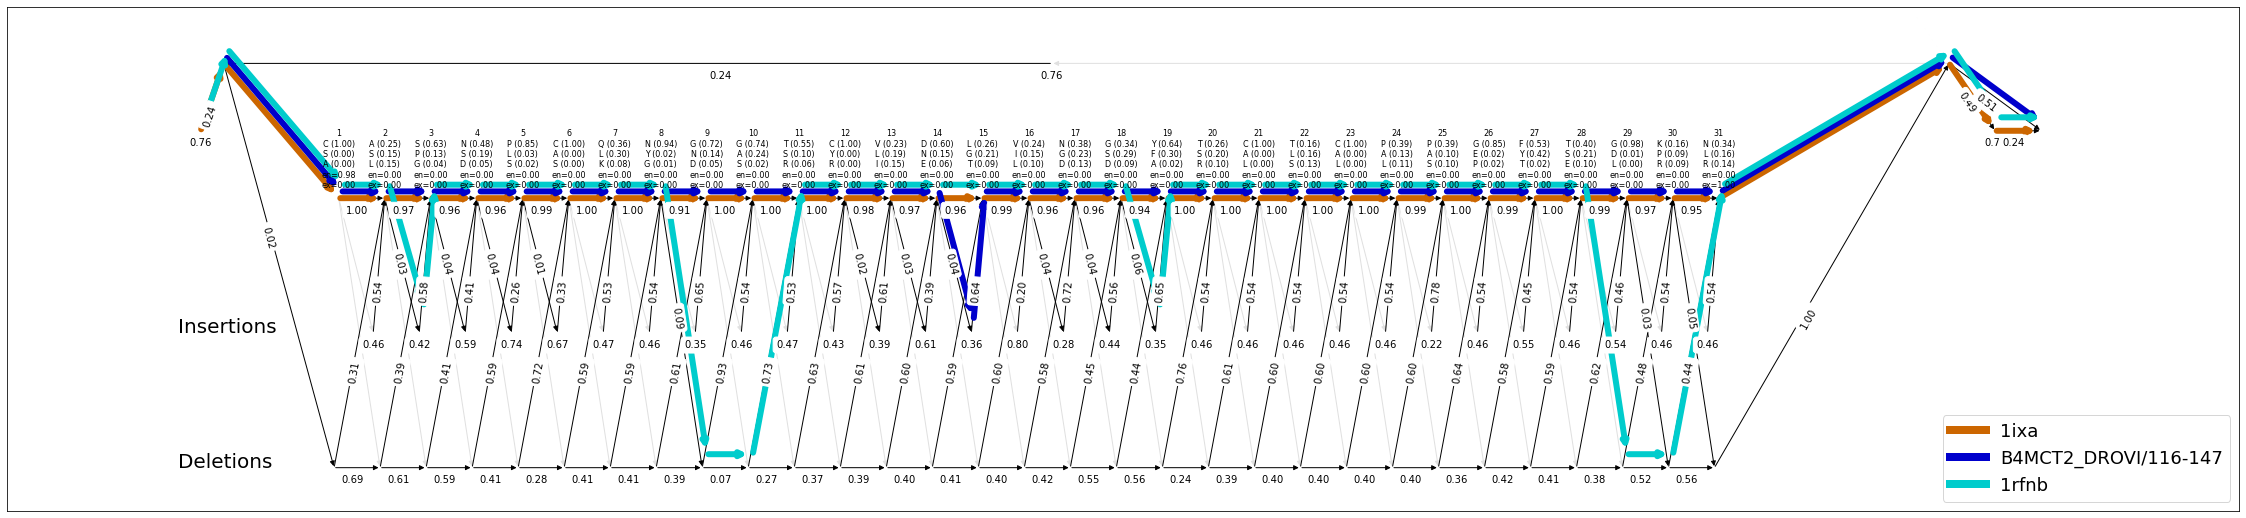

In [61]:
f = "egf"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_trainable_matrix_pair(train_filename, ref_filename, num_runs=1)

# print the alignment
max_seq = 20
msa = best_alignment.to_string()
for s in msa[:max_seq]:
    print(s)
if len(msa) > max_seq:
    print(len(msa) - max_seq, "sequences omitted.")
    
#plot the model
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
msa_hmm.vis.plot_hmm(best_alignment, ax, 
         seq_indices=[best_alignment.indices[0], 11, best_alignment.indices[-1]],
         path_colors=["#CC6600", "#0000cc", "#00cccc"])  

In [ ]:
run_tests(run_learnMSA_family_rate, "family_rate", datasets=["homfam"])

In [ ]:
compare_to_ref("family_rate")

### Experiment 5: Train a local mutation rate per match state

$P(S \mid M_i) = Anc(S, \tau_{i} Q ) \cdot P_{M_i}$

with (as before)

$Anc(S, Q) = S^T \cdot expm(\tau_S Q)$

This could be a more flexible solution than Experiment 1 since any type of fast- or slowly-evolving position can be modeled under a shared substitution matrix.

**The direct approach with m * l different rate matricies (each product of sequence- and match-state-rate yields a unique matrix) is computationally intensive.** An indirect approach is more efficient and has probably the same effect:

Set a number of rate classes $c<l$ and soft-select from the $c$ rate matrices with a learned multinomial distribution per match. 

Also train an insertion specific rate or keep it constant?

In [7]:
def run_learnMSA_local_rate(train_filename, ref_filename, num_rate_classes = 3, num_runs = 3):
    config = dict(msa_hmm.config.default)
    config["emission_init"] = [msa_hmm.config.make_default_emission_init(), 
                               tf.keras.initializers.RandomNormal()]
    config["insertion_init"] = [msa_hmm.config.make_default_insertion_init(), 
                                tf.keras.initializers.RandomNormal()]
    config["frozen_insertions"] = [True, False]
    config["trainable_exchangeabilities"] = False 
    mean_rate = msa_hmm.anc_probs.inverse_softplus(1.)
    std_rate = 1.0
    config["encoder_initializer"] = config["encoder_initializer"] + [tf.keras.initializers.RandomNormal(mean_rate, std_rate)]
    config["kernel_dim"] = [25, num_rate_classes]
    config["num_rate_matrices"] = num_rate_classes
    config["per_matrix_rate"] = True
    config["matrix_rate_l2"] = 1e-1
    config["shared_rate_matrix"] = True
    #config["encoder_weight_extractor"] = get_encoder_weights(keep_tau=False)
    config["emission_func"] = reduce_multinomial_emissions
    config["emission_matrix_generator"] = [msa_hmm.cell.make_default_emission_matrix]*2
    config["emission_prior"] = [msa_hmm.cell.AminoAcidPrior(), SimpleDirichletPrior(1.0, insertions=True)]
    out_filename = "../MSA-HMM-Analysis/results/learnMSA_new/alignments/" + train_filename.split("/")[-1].split(".")[0] + ".projection.fasta"
    return msa_hmm.align.run_learnMSA(num_runs, 
                                      train_filename,
                                      out_filename,
                                      config, 
                                      model_generator=msa_hmm.train.default_model_generator,
                                      ref_filename=ref_filename, 
                                      verbose=True)

Training of 1 independent models on file gluts.fasta
Configuration:
transition_init : {'begin_to_match': <learnMSA.msa_hmm.Configuration.EntryInitializer object at 0x7fb86059a130>, 'match_to_end': <learnMSA.msa_hmm.Configuration.ExitInitializer object at 0x7fb86059abe0>, 'match_to_match': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fb86059a580>, 'match_to_insert': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fb86059a370>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fb86059a8e0>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fb86059aca0>, 'match_to_delete': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fb86059ad30>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fb86059a640>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fb86059a4c0>, 'left_flank_loop': <tensorflow.python.ops.init_ops_v

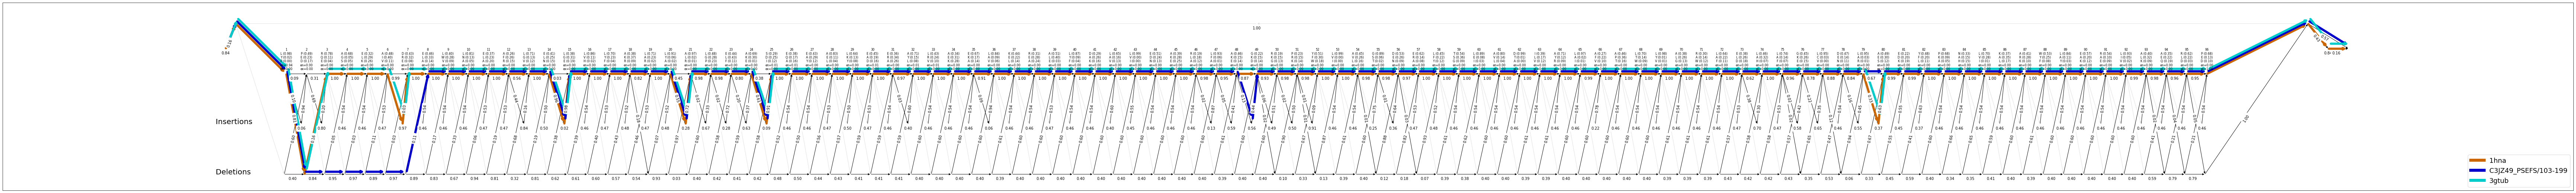

In [8]:
f = "gluts"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_local_rate(train_filename, ref_filename, num_runs=1)
print_and_plot(best_alignment)

Training of 1 independent models on file egf.fasta
Configuration:
transition_init : {'begin_to_match': <learnMSA.msa_hmm.Configuration.EntryInitializer object at 0x7fa3fc30b790>, 'match_to_end': <learnMSA.msa_hmm.Configuration.ExitInitializer object at 0x7fa3fc30b7c0>, 'match_to_match': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fa3fc30b670>, 'match_to_insert': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fa3fc30b730>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fa3fc30bc10>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fa3fc30bc70>, 'match_to_delete': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fa3fc30bd60>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fa3fc30b880>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fa3fc30b970>, 'left_flank_loop': <tensorflow.python.ops.init_ops_v2.

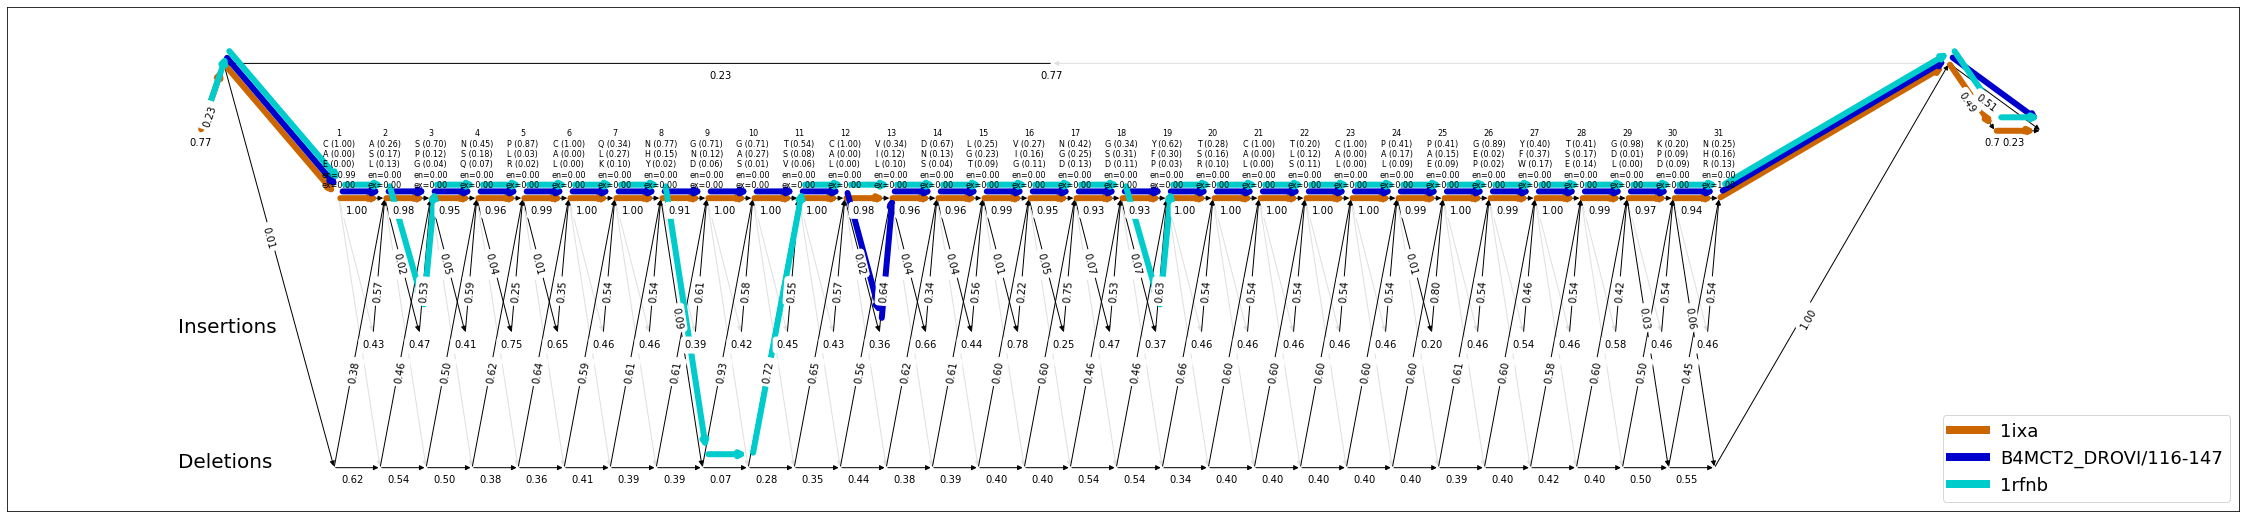

In [8]:
f = "egf"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_local_rate(train_filename, ref_filename, num_runs=1)
print_and_plot(best_alignment)

Training of 1 independent models on file gluts.fasta
Configuration:
transition_init : {'begin_to_match': <learnMSA.msa_hmm.Configuration.EntryInitializer object at 0x7fa3fc30b790>, 'match_to_end': <learnMSA.msa_hmm.Configuration.ExitInitializer object at 0x7fa3fc30b7c0>, 'match_to_match': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fa3fc30b670>, 'match_to_insert': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fa3fc30b730>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fa3fc30bc10>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fa3fc30bc70>, 'match_to_delete': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fa3fc30bd60>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fa3fc30b880>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fa3fc30b970>, 'left_flank_loop': <tensorflow.python.ops.init_ops_v

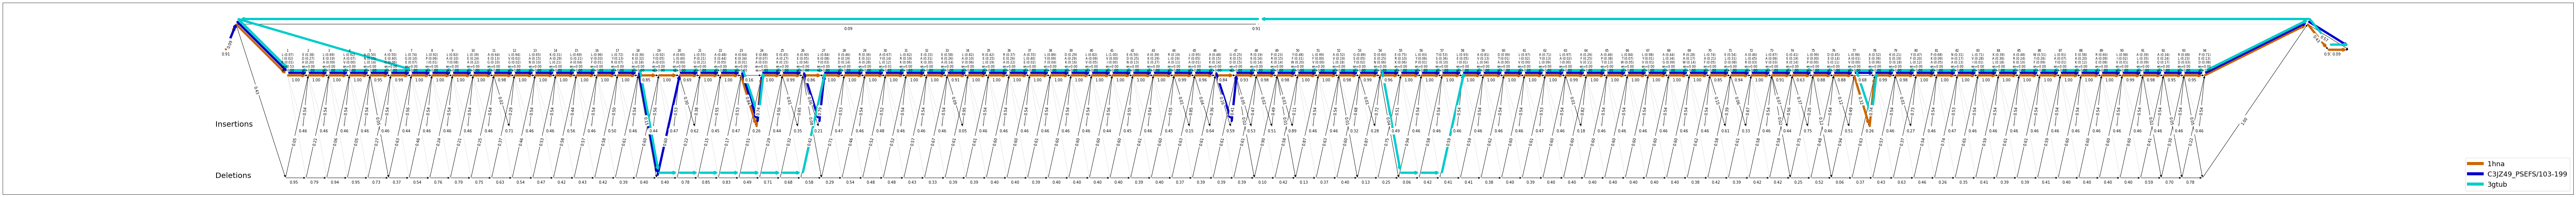

In [5]:
f = "gluts"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_local_rate(train_filename, ref_filename, num_runs=1)
print_and_plot(best_alignment)

Training of 1 independent models on file gluts.fasta
Configuration:
transition_init : {'begin_to_match': <learnMSA.msa_hmm.Configuration.EntryInitializer object at 0x7fa3fc30b790>, 'match_to_end': <learnMSA.msa_hmm.Configuration.ExitInitializer object at 0x7fa3fc30b7c0>, 'match_to_match': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fa3fc30b670>, 'match_to_insert': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fa3fc30b730>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fa3fc30bc10>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fa3fc30bc70>, 'match_to_delete': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fa3fc30bd60>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fa3fc30b880>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fa3fc30b970>, 'left_flank_loop': <tensorflow.python.ops.init_ops_v

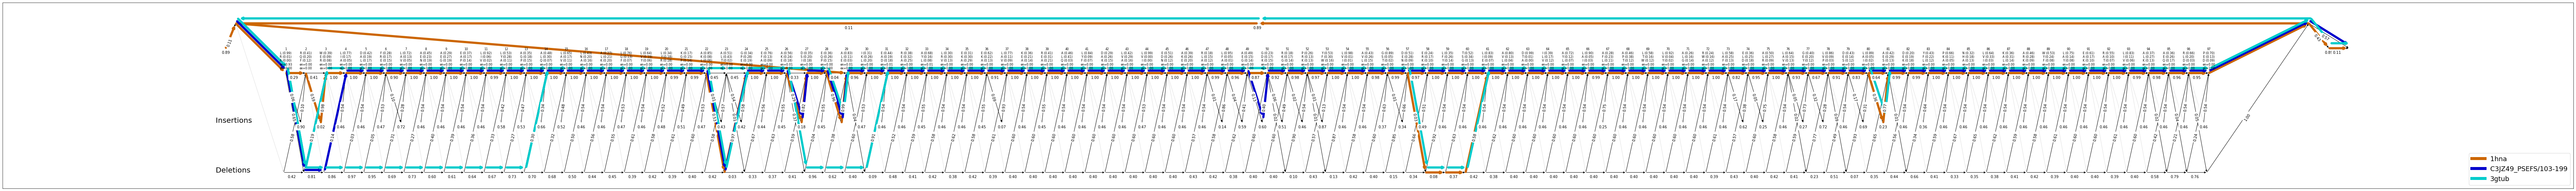

In [6]:
f = "gluts"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_local_rate(train_filename, ref_filename, num_runs=1)
print_and_plot(best_alignment)

Training of 1 independent models on file gluts.fasta
Configuration:
transition_init : {'begin_to_match': <learnMSA.msa_hmm.Configuration.EntryInitializer object at 0x7fa3fc30b790>, 'match_to_end': <learnMSA.msa_hmm.Configuration.ExitInitializer object at 0x7fa3fc30b7c0>, 'match_to_match': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fa3fc30b670>, 'match_to_insert': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fa3fc30b730>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fa3fc30bc10>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fa3fc30bc70>, 'match_to_delete': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fa3fc30bd60>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fa3fc30b880>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fa3fc30b970>, 'left_flank_loop': <tensorflow.python.ops.init_ops_v

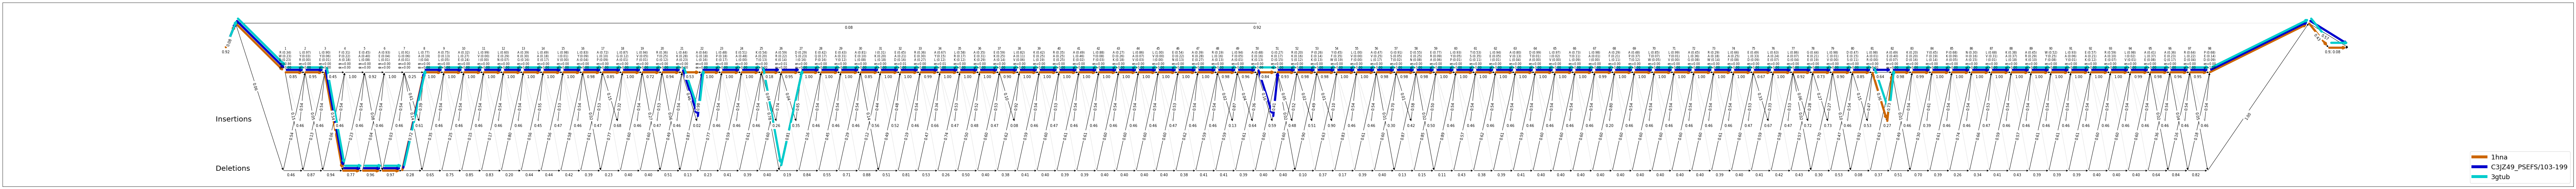

In [7]:
f = "gluts"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_local_rate(train_filename, ref_filename, num_runs=1)
print_and_plot(best_alignment)

rates= tf.Tensor([1.5256767 5.500644  0.3182505], shape=(3,), dtype=float32)


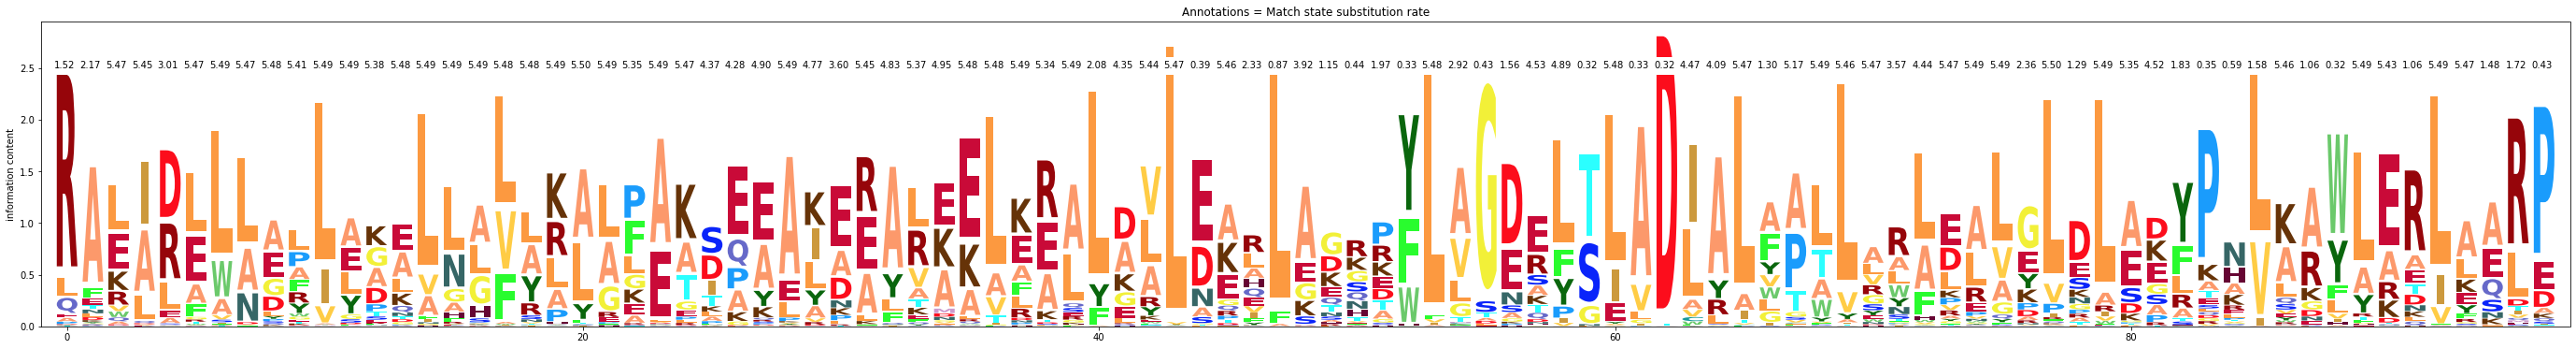

In [17]:
fig, ax = plt.subplots()
msa_hmm.vis.make_logo(best_alignment, ax)
i = [l.name for l in best_alignment.encoder_model.layers].index("AncProbsLayer")
anc_probs_layer = best_alignment.encoder_model.layers[i]
rates = anc_probs_layer.make_per_matrix_rate()
print("rates=", rates)
model_length = best_alignment.msa_hmm_layer.cell.length
rate_multinomial = best_alignment.msa_hmm_layer.cell.make_B()[1][1:model_length+1, :-1]
rates = tf.cast(rates, rate_multinomial.dtype)
match_rates = tf.linalg.matvec(rate_multinomial, rates)
for i,p in enumerate(match_rates):
    plt.annotate("%.2f" % p, (i-0.5, 2.5), backgroundcolor="w")
plt.title("Annotations = Match state substitution rate");

Training of 1 independent models on file egf.fasta
Configuration:
transition_init : {'begin_to_match': <learnMSA.msa_hmm.Configuration.EntryInitializer object at 0x7ff6183e4f40>, 'match_to_end': <learnMSA.msa_hmm.Configuration.ExitInitializer object at 0x7ff6183e4580>, 'match_to_match': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7ff6183e4400>, 'match_to_insert': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7ff6183e40a0>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7ff6183e4370>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7ff6183e4550>, 'match_to_delete': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7ff6183e4640>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7ff6183e43d0>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7ff6183e4220>, 'left_flank_loop': <tensorflow.python.ops.init_ops_v2.

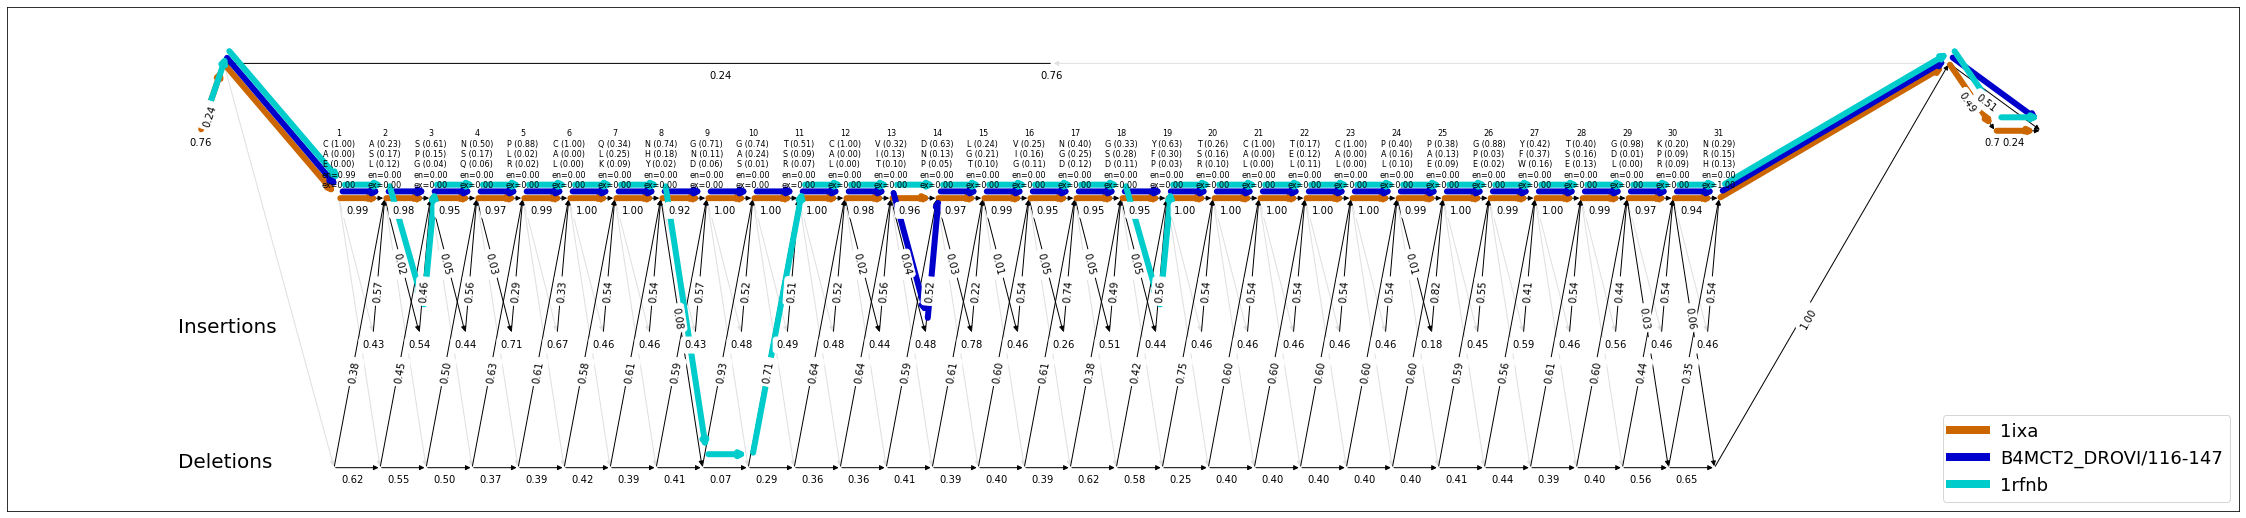

In [22]:
f = "egf"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_local_rate(train_filename, ref_filename, num_runs=1)

# print the alignment
max_seq = 20
msa = best_alignment.to_string()
for s in msa[:max_seq]:
    print(s)
if len(msa) > max_seq:
    print(len(msa) - max_seq, "sequences omitted.")

#plot the model
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
msa_hmm.vis.plot_hmm(best_alignment, ax, 
         seq_indices=[best_alignment.indices[0], 11, best_alignment.indices[-1]],
         path_colors=["#CC6600", "#0000cc", "#00cccc"])  

rates= tf.Tensor([0.24850678 0.95231193 2.088272  ], shape=(3,), dtype=float32)


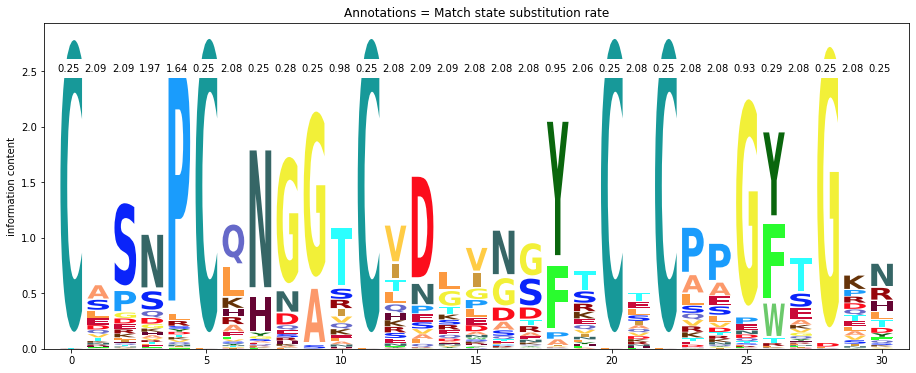

In [23]:
fig, ax = plt.subplots()
msa_hmm.vis.make_logo(best_alignment, ax)
i = [l.name for l in best_alignment.encoder_model.layers].index("AncProbsLayer")
anc_probs_layer = best_alignment.encoder_model.layers[i]
rates = anc_probs_layer.make_per_matrix_rate()
print("rates=", rates)
model_length = best_alignment.msa_hmm_layer.cell.length
rate_multinomial = best_alignment.msa_hmm_layer.cell.make_B()[1][1:model_length+1, :-1]
rates = tf.cast(rates, rate_multinomial.dtype)
match_rates = tf.linalg.matvec(rate_multinomial, rates)
for i,p in enumerate(match_rates):
    plt.annotate("%.2f" % p, (i-0.5, 2.5), backgroundcolor="w")
plt.title("Annotations = Match state substitution rate");

In [ ]:
run_tests(run_learnMSA_local_rate, "local_rate_3_w3", datasets=["balifam10000"])

In [37]:
compare_to_baseline("local_rate_5")

homfam
scores mean: 79.87978826871651 ref_scores mean: 79.64971567684702
[('gluts', -14.295, 46.4), ('rvp', -10.555, 22.395), ('int', -9.187, 72.829), ('adh', -6.604, 60.886), ('tgfb', -5.527, 78.27)] ... [('PDZ', 7.911, 93.241), ('KAS', 8.677, 53.008), ('HMG_box', 9.065, 97.309), ('oxidored_q6', 10.194, 65.116), ('phc', 29.68, 66.777)]
balifam10000
scores mean: 75.6067605221088 ref_scores mean: 75.48473565061919
[('PF02836.10000', -10.493, 79.102), ('PF00078.10000', -9.924, 77.68), ('PF00202.10000', -7.928, 35.487), ('PF07679.10000', -6.7, 77.132), ('PF13393.10000', -4.914, 39.989)] ... [('PF01381.10000', 3.219, 67.025), ('PF02878.10000', 10.464, 83.974), ('PF01814.10000', 10.578, 92.556), ('PF13365.10000', 10.97, 37.68), ('PF04082.10000', 12.915, 66.282)]


In [38]:
compare_to_baseline("local_rate_3")

homfam
scores mean: 79.15385638125306 ref_scores mean: 79.64971567684702
[('gluts', -18.689, 42.005), ('rvp', -12.043, 20.907), ('tgfb', -8.523, 75.274), ('lyase_1', -7.728, 64.543), ('p450', -7.707, 69.06)] ... [('hormone_rec', 5.208, 71.54), ('blmb', 6.356, 70.828), ('toxin', 6.876, 92.059), ('KAS', 8.971, 53.301), ('HMG_box', 9.065, 97.309)]
balifam10000
scores mean: 76.15588625287506 ref_scores mean: 75.48473565061919
[('PF00202.10000', -9.827, 33.588), ('PF07679.10000', -6.395, 77.436), ('PF00505.10000', -6.066, 90.889), ('PF02836.10000', -5.713, 83.882), ('PF00232.10000', -5.275, 81.761)] ... [('PF04082.10000', 8.487, 61.854), ('PF01814.10000', 9.109, 91.087), ('PF02878.10000', 9.272, 82.781), ('PF13365.10000', 14.236, 40.947), ('PF00625.10000', 14.842, 41.228)]


In [39]:
compare_to_baseline("local_rate_3_w")

homfam
scores mean: 78.84221566669622 ref_scores mean: 79.64971567684702
[('p450', -73.712, 3.056), ('Sulfotransfer', -34.697, 42.004), ('ghf13', -20.175, 30.994), ('gluts', -13.495, 47.2), ('blmb', -13.136, 51.336)] ... [('rhv', 7.124, 23.097), ('HMG_box', 7.507, 95.751), ('sti', 9.671, 87.601), ('oxidored_q6', 16.667, 71.589), ('phc', 41.508, 78.605)]
balifam10000
scores mean: 75.3077867304253 ref_scores mean: 75.48473565061919
[('PF00037.10000', -10.273, 80.819), ('PF07679.10000', -8.444, 75.388), ('PF00202.10000', -7.387, 36.028), ('PF07686.10000', -7.082, 81.305), ('PF00150.10000', -4.365, 55.858)] ... [('PF04082.10000', 2.814, 56.181), ('PF01814.10000', 2.938, 84.917), ('PF02878.10000', 9.139, 82.649), ('PF13365.10000', 12.868, 39.579), ('PF00625.10000', 13.486, 39.872)]


In [40]:
compare_to_baseline("local_rate_3_w2")

homfam
scores mean: 79.31076810777951 ref_scores mean: 79.64971567684702
[('tRNA-synt_2b', -21.458, 30.016), ('lyase_1', -16.025, 56.247), ('gluts', -8.695, 52.0), ('Sulfotransfer', -7.223, 69.478), ('int', -7.016, 75.0)] ... [('kringle', 7.069, 92.718), ('rhv', 7.229, 23.202), ('KAS', 9.034, 53.364), ('HMG_box', 9.065, 97.309), ('phc', 20.434, 57.531)]
balifam10000
scores mean: 75.61950628019991 ref_scores mean: 75.48473565061919
[('PF13393.10000', -10.234, 34.668), ('PF00202.10000', -10.16, 33.255), ('PF07679.10000', -6.949, 76.883), ('PF00078.10000', -5.341, 82.264), ('PF00505.10000', -3.565, 93.389)] ... [('PF07654.10000', 3.469, 84.898), ('PF01381.10000', 3.819, 67.625), ('PF00625.10000', 7.873, 34.259), ('PF04082.10000', 12.961, 66.328), ('PF13365.10000', 17.727, 44.438)]


In [41]:
compare_to_baseline("local_rate_3_w3")

homfam
scores mean: 79.74927244537153 ref_scores mean: 79.64971567684702
[('peroxidase', -19.29, 49.484), ('p450', -9.821, 66.946), ('gluts', -8.916, 51.779), ('adh', -5.799, 61.691), ('aat', -5.346, 77.652)] ... [('sti', 7.254, 85.183), ('KAS', 8.51, 52.84), ('HMG_box', 9.065, 97.309), ('seatoxin', 9.954, 80.787), ('phc', 18.784, 55.881)]
balifam10000
scores mean: 75.8939353476267 ref_scores mean: 75.48473565061919
[('PF13393.10000', -10.707, 34.196), ('PF00202.10000', -8.82, 34.594), ('PF07679.10000', -5.731, 78.101), ('PF00505.10000', -3.751, 93.204), ('PF00037.10000', -2.809, 88.283)] ... [('PF01381.10000', 2.953, 66.758), ('PF02878.10000', 7.55, 81.06), ('PF00625.10000', 8.904, 35.29), ('PF04082.10000', 12.915, 66.282), ('PF13365.10000', 15.695, 42.405)]


### Experiment 6: Use a (fixed) mixture of 2-3 rate matricies and learn the mixture coefficients

Pretrained mixture models already exist and should be solid (same authors as LG matrix that learnMSA uses). For instance, there is a secondary structure based mixture that was learned with class supervision (extended/helix/other). It would be interesting whether learnMSA can learn mixture coefficients per match state that reflect the real biologic background of this position.

### Experiment 7: Can we incorporate ClaMSA? Train $Q_1, .. , Q_M$?

### Experiment 8: Use a fixed symmetric part $R$ but replace the generic $\pi$ with the distribution from the match state